In [7]:
using Pkg
Pkg.add("Ipopt")
Pkg.add("JuMP")

   Resolving package versions...
  No Changes to `C:\Users\batagoda\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\batagoda\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
    Unitful Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\Unitful\5WYj5_tm3GZ.ji.pidfile)
    ColorSchemes Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\ColorSchemes\EO5fj_tm3GZ.ji.pidfile)
  ✓ FFMPEG
  ✓ Qt6Base_jll
  ✓ GR_jll
    GR Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\GR\NDU5Y_tm3GZ.ji.pidfile)
  ✓ Unitful
  ✓ ColorSchemes
    UnitfulLatexify Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\UnitfulLatexify\trCzg_tm3GZ.ji.pidfile)
    PlotUtils Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\PlotUtils\YveHG_tm3GZ.ji

In [82]:
using CSV
using JuMP
using Ipopt
using DataFrames
using Plots
using LinearAlgebra

In [35]:
trajectory_data = DataFrame(CSV.File("traj2d.csv"));
ref_trajectory= Matrix(trajectory_data)[]

1000×13 Matrix{Float64}:
  0.01  1.0  9.5888e-8     1.5708  …  0.573312  -2.57453e-15  -0.2688
  0.02  1.0  7.66208e-7    1.5708     0.570624  -2.57453e-15  -0.2688
  0.03  1.0  2.58293e-6    1.5708     0.567936  -2.57453e-15  -0.2688
  0.04  1.0  6.11533e-6    1.5708     0.565248  -2.57453e-15  -0.2688
  0.05  1.0  1.193e-5      1.5708     0.56256   -2.57453e-15  -0.2688
  0.06  1.0  2.05908e-5    1.5708  …  0.559872  -2.57453e-15  -0.2688
  0.07  1.0  3.26591e-5    1.5708     0.557184  -2.57453e-15  -0.2688
  0.08  1.0  4.86932e-5    1.5708     0.554496  -2.57453e-15  -0.2688
  0.09  1.0  6.92492e-5    1.5708     0.551808  -2.57453e-15  -0.2688
  0.1   1.0  9.488e-5      1.5708     0.54912   -2.57453e-15  -0.2688
  0.11  1.0  0.000126136   1.5708  …  0.546432  -2.57453e-15  -0.2688
  0.12  1.0  0.000163566   1.5708     0.543744  -2.57453e-15  -0.2688
  0.13  1.0  0.000207713   1.5708     0.541056  -2.57453e-15  -0.2688
  ⋮                                ⋱  ⋮                       
  

In [62]:
N = size(ref_trajectory)[1]
ref_trajectory[1,5:6][2]
N

1000

In [110]:
function A_k(x, dxdy)
    A = [0 0  -dxdy[2];
         0 0  dxdy[1];
         0 0  0];
    return A
end

function B_k(x, dxdy)
    phi = atan( 2*(dxdy[1]*dxdy[5] - dxdy[4]*dxdy[2]) / (dxdy[1]^2 + dxdy[2]^2)^(3/2) );
    theta = atan( dxdy[2] / dxdy[1] );
    if isnan(phi)
        phi = 0
    end
    if isnan(theta)
        theta = 0
    end
    v = dxdy[1] / cos(theta);
    B = [cos(theta) 0;
         sin(theta) 0;
         1/tan(phi) (v/2)*sec(phi)^2];
    return B
end


# For each entry in the reference trajectory, comput a A and B matrix
A = zeros(3,3,N)
B = zeros(3,2,N)
for i in 1:N
    #println(N)
    x = ref_trajectory[i,5:6]
    dxdy = ref_trajectory[i,5:9]
    A[:,:,i] = A_k(x, dxdy)
    B[:,:,i] = B_k(x, dxdy)
end


In [114]:
B[:,:,1]

3×2 Matrix{Float64}:
 5.16826e-15  0.0
 1.0          0.0
 2.08654e10   1.43408e-5

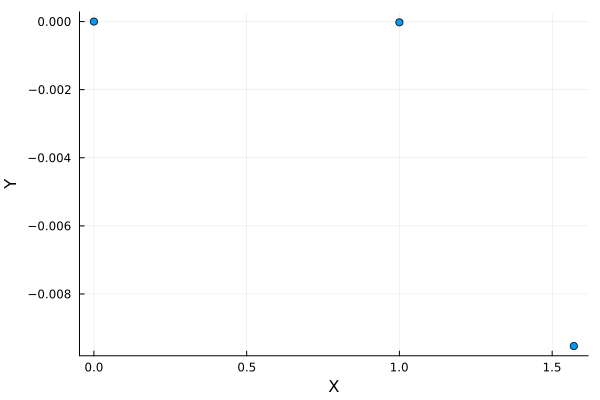

In [136]:



# Parameters
#N = 100 # Number of time steps
L = 2 # Wheelbase, example value
r_safe = 0.0 # Safety radius
obstacles = [(1, 2, 1)] # Each tuple: (o_x, o_y, r)

# Initial conditions
x0 = ref_trajectory[1, 2:4] # Initial state [x, y, theta]
#initial_guess = repmat(x0, N)

# Bounds
xmin = fill(-Inf, 3)
xmax = fill(Inf, 3)
umin = [-5, -π/4] # velocity and steering angle limits
umax = [5, π/4]

# Weight matrices
Q = I(3)
R = I(2)
P = I(3)

# Create JuMP model
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))

# Define decision variables
@variable(model, x[1:N, 1:3])
@variable(model, u[1:N, 1:2])

# Objective function
# @objective(model, Min,
# sum( (x[k, 1:2] - ref_trajectory[k, 2:3]).^2 for k = 1:N) +
# (x[N, 1:2] - ref_trajectory[N, 1:2]).^2 +
# sum( u[k, :].^2 for k = 1:N-1)
# )

@objective(model, Min,
sum( (x[k, 1] - ref_trajectory[k, 2])^2 for k = 1:N) +
sum( (x[k, 2] - ref_trajectory[k, 3])^2 for k = 1:N) +
sum( (x[k, 3] - ref_trajectory[k, 4])^2 for k = 1:N) +
(x[N, 1] - ref_trajectory[N, 2])^2 +
(x[N, 2] - ref_trajectory[N, 3])^2 +
(x[N, 3] - ref_trajectory[N, 4])^2 +
sum( u[k, 1]^2 for k = 1:N-1) +
sum( u[k, 2]^2 for k = 1:N-1)
)


# System dynamics constraints
for k = 1:N-1
    @constraint(model, x[k+1, :] .== A[:,:,k] * x[k, :] + B[:,:,k]* u[k, :])
end

#State and control bounds
for k = 1:N
    @constraint(model, ref_trajectory[k,2] - 1 .<= x[k, 1] .<= ref_trajectory[k,2] + 1)
    @constraint(model, ref_trajectory[k,3] - 1 .<= x[k, 2] .<= ref_trajectory[k,3] + 1)
end

for k = 1:N
    @constraint(model, umin .<= u[k, :] .<= umax)
end

# Obstacle avoidance constraints
for j = 1:length(obstacles)
   for k = 1:N
       @constraint(model, (x[k,1] - obstacles[j][1])^2 + (x[k, 2] - obstacles[j][2])^2 >= (obstacles[j][3] + r_safe)^2)
   end
end

# Set initial condition
@constraint(model, x[1,:] .== x0)

# set final condition
@constraint(model, x[N, :] .== ref_trajectory[N, 2:4])

# Solve the optimization problem
optimize!(model)

# Retrieve optimized trajectory
x_opt = value.(x)




x_data = x_opt[1, :]
y_data = x_opt[2, :]

scatter(x_data, y_data, xlabel="X", ylabel="Y", legend=false)

In [137]:
x_opt[N,:],ref_trajectory[N, 2:4]
x_opt[1,:],ref_trajectory[1, 2:4]

([1.0, 9.58879999999585e-8, 1.57079632679489], [1.0, 9.58879999999585e-8, 1.57079632679489])

In [102]:
a[1,:]

3-element Vector{VariableRef}:
 a[1,1]
 a[1,2]
 a[1,3]